## Imports:

In [4]:
import torch 
import unidecode
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from models.charRNN import make_charRNN, get_random_batch, generate
from utils import n_chars, check_validity, check_novelty, strsmis2listsmis, list2txt, get_props

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data preparation

In [6]:
file = unidecode.unidecode(open('all_data/s_100_str_+1M.txt').read())

In [7]:
file[0:100]

'<COc1ccc2[C@@H]3[C@H](COc2c1)C(C)(C)OC4=C3C(=O)C(=O)C5=C4OC(C)(C)[C@@H]6COc7cc(OC)ccc7[C@H]56><C[S+]'

## Make the model

In [12]:
model_name = 'G'
# model_name = None
rnn, optimizer, criterion = make_charRNN(n_chars=n_chars, hidden_size=512, 
                                         num_layers=3, lr=0.0005, pretrained_file=model_name)

# pretrained_file='G'          to use our pretrained model
# pretrained_file=None         to train a new model

In [13]:
print(rnn)

RNN(
  (embed): Embedding(56, 30)
  (gru): GRU(30, 512, num_layers=3, batch_first=True)
  (fc): Linear(in_features=512, out_features=56, bias=True)
)


# Train

In [14]:
def train(chunk_len=256, n_epochs=2500, print_every=10):
    print("=> Starting training...")
    Ls = []
    for epoch in range(1, n_epochs + 1):
        inp, target = get_random_batch(file, chunk_len)
        hidden = rnn.init_hidden()

        rnn.zero_grad()
        loss = 0
        inp = inp.to(device)
        target = target.to(device)
        
        for i in range(chunk_len): 
            output, hidden = rnn(inp[:, i], hidden)
            loss += criterion(output, target[:,i])
        loss.backward()
        optimizer.step()
        loss = loss.item()/(chunk_len)
        Ls.append(loss)
        if epoch % print_every == 0:  
            print(f'Loss: {loss}')
        print("epoch number : ", epoch)            
    return Ls

In [17]:
Losses = train(chunk_len=256, n_epochs=2500, print_every=10)

Text(0.5, 0, 'Training iterations')

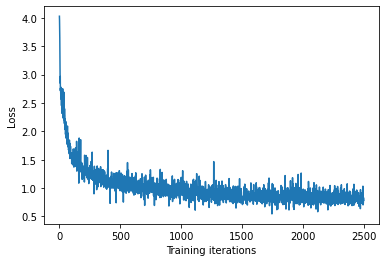

In [19]:
plt.plot(Losses)
plt.ylabel('Loss')
plt.xlabel('Training iterations')
# plt.savefig('G_loss.png', dpi=300)

In [20]:
# filename = 'models/pretrained/G.pth'
# torch.save(rnn.state_dict(), filename)

# Test: -----------------------------------------------------------
**Keep changing the temperature:**

How it works: https://stackoverflow.com/questions/58764619/why-should-we-use-temperature-in-softmax

In [18]:
# temp_used = 1
# temp_used = 0.80
# temp_used = 0.60
# temp_used = 0.40
# temp_used = 0.20

temp_used = 0.50 #optimal

In [19]:
temp_used

0.5

## 0. generate k molecules:
* set the desired max length and temperature

In [20]:
n_ep = 10000
all_smis = []
for ep in range(n_ep):
    length = 102 
    ic = '<'
    smi = generate(rnn, initial_str=ic, predict_len=length, temperature=temp_used)
    all_smis.append(smi)
#     print("iteration:", ep)

In [21]:
### save the list of generated smiles if you want
# filename = model_name + '_all_smis_.txt'
# path = 'gen_smis/' + filename
# list2txt(path, mylist=all_smis)

## 1. How many among all_smis are valid:

In [22]:
val_smis = []
for i, s in enumerate(all_smis):
    v = check_validity(s)
    if v == 1:
        val_smis.append(s)
#         print("mol at:", i, " : verified")

In [37]:
print("There is ", len(val_smis), "valid molecule among the", len(all_smis), "generated")
print("meaning a percent of: ", 100 * len(val_smis)/ len(all_smis), "%")

## 2. How many among val_smis are novel:

In [24]:
###----- but first, convert the dataset which is a string file to list
smis_list = strsmis2listsmis(file)
len(smis_list)

1498669

In [26]:
val_and_nov_smis = []
for i, s in enumerate(val_smis):
    nv = check_novelty(s, smis_list)
    if nv == 1:
        val_and_nov_smis.append(s)
#         print("mol at:", i, " : verified")

In [36]:
print("There is ", len(val_and_nov_smis), "valid & novel molecule among the", len(all_smis), "generated")
print("meaning a percent of: ", 100 * len(val_and_nov_smis)/ len(val_smis), "%")

## 3. How many among valid_and_novel_smis are unique 
* meaning, they don't have duplicates/were not repeated in the generated molecules

In [28]:
def check_uniqueness(smis_list):
    return list(set(smis_list))

In [29]:
val_nov_and_unique_smis = check_uniqueness(val_and_nov_smis)

In [35]:
len(val_nov_and_unique_smis)

In [33]:
print("There is ", len(val_nov_and_unique_smis), "valid, novel and unique molecule among the", len(all_smis), "generated")
print("meaning, a percent of : ", 100 * len(val_nov_and_unique_smis)/ len(val_and_nov_smis), "%")

## 4. Diversity (intDiv) of the valid, novel, and unique smiles:
* using the moses library https://github.com/molecularsets/moses

In [34]:
import moses
moses.metrics.internal_diversity(val_nov_and_unique_smis)